Name: Zixi Wang

Github Username: lacunaxu

USC ID: 2854187591

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
import os

In [155]:
#part (ab)
folder_paths = ["bending1", "bending2", "cycling", "lying", 
                "sitting", "standing", "walking"]

columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 
           'var_rss13', 'avg_rss23', 'var_rss23']

train_data_name = []
train_data = []
test_data_name = []
test_data = []
expected_columns = 7
problematic_lines = []

def detect_separator(file_path):
    with open(file_path, 'r') as file:
        for _ in range(5):
            next(file)
        sample = file.read(200)  
    
    if ',' in sample:
        return ','
    else:
        return '\s+' 

def process_file(file_path):
    sep = detect_separator(file_path)
    df = pd.read_csv(file_path, comment='#', header=None, usecols=range(7), sep=sep)
    df.columns = columns
    
    return df

for folder in folder_paths:
    overall_path = os.getcwd()
    new_path = os.path.dirname(overall_path)
    path = os.path.join(new_path, 'data', 'AReM', folder)
    
    files = os.listdir(path)
    
    for idx, file in enumerate(files):
        
        file_path = os.path.join(path, file)    
        df = process_file(file_path)
        if folder == "bending1" or folder == "bending2":
            if idx < 2:
                test_data.append(df)
                test_data_name.append(folder)
            else:
                train_data.append(df)
                train_data_name.append(folder)
        else:
            if idx < 3:
                test_data.append(df)
                test_data_name.append(folder)
            else:
                train_data.append(df)
                train_data_name.append(folder)

print(f"Test Data: {len(test_data)} files")
print(f"Train Data: {len(train_data)} files")

Test Data: 19 files
Train Data: 69 files


In [156]:
test_data

[       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      39.25       0.43      22.75       0.43      33.75        1.3
 1       250      39.25       0.43      23.00       0.00      33.00        0.0
 2       500      39.25       0.43      23.25       0.43      33.00        0.0
 3       750      39.50       0.50      23.00       0.71      33.00        0.0
 4      1000      39.50       0.50      24.00       0.00      33.00        0.0
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      43.33       0.47      25.00       0.00      30.00        0.0
 476  119000      43.50       0.50      25.50       0.50      30.00        0.0
 477  119250      43.50       0.50      24.75       0.43      30.00        0.0
 478  119500      43.50       0.50      24.33       0.47      30.00        0.0
 479  119750      43.50       0.50      24.25       0.43      30.00        0.0
 
 [480 rows x 7 columns],
        time  avg_rss12  

In [157]:
train_data

[       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      42.00       0.71      21.25       0.43      30.00       0.00
 1       250      41.50       0.50      20.25       1.48      31.25       1.09
 2       500      41.50       0.50      14.25       1.92      33.00       0.00
 3       750      40.75       0.83      15.75       0.43      33.00       0.00
 4      1000      40.00       0.71      20.00       2.74      32.75       0.43
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      42.50       0.50      20.00       0.82      36.00       0.00
 476  119000      42.67       0.47      21.00       0.00      36.33       0.47
 477  119250      44.33       0.94      21.00       0.00      36.33       0.47
 478  119500      45.25       0.43      26.75       1.79      36.00       0.00
 479  119750      47.25       0.83      29.75       0.43      35.25       1.30
 
 [480 rows x 7 columns],
        time  avg_rss12  

c(i)
 Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)
 
Based on my research:
"In time series classification, time-domain features are extracted directly from the raw time series data. These features help capture the statistical properties and patterns of the data over time."

Here are some time-domain features:
Mean, Standard Deviation, Minimum and Maximum values, range, median, skewness, quartiles and IQR, Root Mean Square, Absolute Mean Difference, Entropy, trend

In [158]:
#2(ii)
def extract_features(df):
    features = {}
    for i, col in enumerate(df.columns[1:]): 
        features[f'min_{i+1}'] = df[col].min()
        features[f'max_{i+1}'] = df[col].max()
        features[f'mean_{i+1}'] = df[col].mean()
        features[f'median_{i+1}'] = df[col].median()
        features[f'std_{i+1}'] = df[col].std()
        features[f'1st_quart_{i+1}'] = df[col].quantile(0.25)
        features[f'3rd_quart_{i+1}'] = df[col].quantile(0.75)
    return features

train_features = pd.DataFrame([extract_features(df) for df in train_data])
test_features = pd.DataFrame([extract_features(df) for df in test_data])

total_features = pd.concat([train_features, test_features], axis=0).round(2)
print(total_features.head())


   min_1  max_1  mean_1  median_1  std_1  1st_quart_1  3rd_quart_1  min_2  \
0  35.00  47.40   43.95     44.33   1.56        43.00        45.00    0.0   
1  33.00  47.75   42.18     43.50   3.67        39.15        45.00    0.0   
2  33.00  45.75   41.68     41.75   2.24        41.33        42.75    0.0   
3  37.00  48.00   43.45     43.25   1.39        42.50        45.00    0.0   
4  36.25  48.00   43.97     44.50   1.62        43.31        44.67    0.0   

   max_2  mean_2  ...  std_5  1st_quart_5  3rd_quart_5  min_6  max_6  mean_6  \
0   1.70    0.43  ...   2.00        35.36        36.50    0.0   1.79    0.49   
1   3.00    0.70  ...   3.85        30.46        36.33    0.0   2.18    0.61   
2   2.83    0.54  ...   2.41        28.46        31.25    0.0   1.79    0.38   
3   1.58    0.38  ...   2.49        22.25        24.00    0.0   5.26    0.68   
4   1.50    0.41  ...   3.32        20.50        23.75    0.0   2.96    0.56   

   median_6  std_6  1st_quart_6  3rd_quart_6  
0      0.

In [159]:
scaler_min_max = MinMaxScaler()
normalized_min_max = scaler_min_max.fit_transform(total_features)
normalized_data_min_max = pd.DataFrame(normalized_min_max, 
                                       columns=total_features.columns).round(2)

scaler_z_score = StandardScaler()
normalized_z_score = scaler_z_score.fit_transform(total_features)
normalized_data_z_score = pd.DataFrame(normalized_z_score, 
                                       columns=total_features.columns).round(2)

print("Min-Max Normalized Features DataFrame:\n")
print(normalized_data_min_max.head())

print("Z-score Normalized Features DataFrame:")
print(normalized_data_z_score.head())


Min-Max Normalized Features DataFrame:

   min_1  max_1  mean_1  median_1  std_1  1st_quart_1  3rd_quart_1  min_2  \
0   0.73   0.66    0.83      0.85   0.20         0.80         0.67    0.0   
1   0.69   0.68    0.75      0.81   0.48         0.64         0.67    0.0   
2   0.69   0.60    0.73      0.74   0.29         0.73         0.59    0.0   
3   0.77   0.69    0.81      0.80   0.18         0.78         0.67    0.0   
4   0.76   0.69    0.83      0.85   0.21         0.81         0.66    0.0   

   max_2  mean_2  ...  std_5  1st_quart_5  3rd_quart_5  min_6  max_6  mean_6  \
0   0.08    0.09  ...   0.04         1.00         1.00    0.0   0.00    0.03   
1   0.15    0.15  ...   0.34         0.86         0.99    0.0   0.03    0.07   
2   0.14    0.12  ...   0.11         0.80         0.83    0.0   0.00    0.00   
3   0.07    0.08  ...   0.12         0.62         0.60    0.0   0.29    0.10   
4   0.06    0.09  ...   0.26         0.57         0.59    0.0   0.10    0.06   

   median_6  std

In [160]:
std_estimates = total_features.std()
confidence_intervals = {}

for column in total_features.columns:
    bootstrap_stds = []
    for i in range(1000):
        sample = total_features[column].sample(frac=1, replace=True)
        bootstrap_stds.append(sample.std())

    lower_percentile = (1 - 0.9) / 2
    upper_percentile = 1 - lower_percentile
    lower = np.percentile(bootstrap_stds, lower_percentile * 100)
    upper = np.percentile(bootstrap_stds, upper_percentile * 100)

    confidence_intervals[column] = (std_estimates[column], lower, upper)

result_df = pd.DataFrame(confidence_intervals, 
                                      index=['Standard Deviation', 
                                             'CI Lower Bound', 
                                             'CI Upper Bound']).T.round(4)

result_df['CI Length'] = result_df['CI Upper Bound'] - result_df['CI Lower Bound']

print("The 90% bootstrap confidence interval for the standard deviation of each feature is:")
print(result_df)


The 90% bootstrap confidence interval for the standard deviation of each feature is:
             Standard Deviation  CI Lower Bound  CI Upper Bound  CI Length
min_1                    9.5700          8.2484         10.8088     2.5604
max_1                    4.3944          3.3938          5.2766     1.8828
mean_1                   5.3352          4.6842          5.8656     1.1814
median_1                 5.4402          4.7894          6.0245     1.2351
std_1                    1.7721          1.5810          1.9447     0.3637
1st_quart_1              6.1535          5.5347          6.6177     1.0830
3rd_quart_1              5.1390          4.3143          5.8130     1.4987
min_2                    0.0000          0.0000          0.0000     0.0000
max_2                    5.0627          4.6120          5.3973     0.7853
mean_2                   1.5743          1.4034          1.7082     0.3048
median_2                 1.4121          1.2402          1.5449     0.3047
std_2          

I would choose the following three most important time domain features:

By side-by-side comparison:
Among min, min_1 is the most important feature because its standard deviation is larger and the confidence interval is shorter, indicating significant changes in the data.
Among max, max_5 is the most important feature because its standard deviation is high and the confidence interval is small, indicating that the data changes greatly and the estimate is stable.
In mean, mean_1 is the most important feature because its standard deviation is large and the confidence interval is narrow, indicating that its estimation accuracy is high and there is large variation in the data.
Among the median, median_1 is the most important feature because its standard deviation is high and the confidence interval is short, indicating better discrimination in the data.
In Std, std_5 is the most important feature because its standard deviation is higher and the confidence interval is shorter, indicating greater data variation and better estimation accuracy.
In Q1, 1st_quart_1 is the most important feature because it has a larger standard deviation and shorter confidence interval.
In Q3, 3rd_quart_1 is the most important feature, exhibiting higher standard deviation and shorter confidence interval.

From these seven statistics, I will further select the three most important time domain features. I will consider them based on the size of the standard deviation, the length of the confidence interval, and the representativeness of the statistics. Among them: mean_1, min_5 , and max_1 are the most representative

The standard deviation of mean_1 is 5.3352 and the confidence interval is [4.7079, 5.8833]. The confidence interval is relatively narrow, indicating that the estimate is stable, and the mean is an important feature in describing the central trend of the data.

min_5 (minimum value of the fifth time series): min_5 has a standard deviation of 6.1240 and a confidence interval of [4.3976, 7.5035]. Although the confidence interval is slightly wider, its standard deviation is larger, indicating that there is more variation in the data. The minimum value can reflect the lower bound of the data and is an important statistical feature.

max_1 (the maximum value of the first time series): max_1 has a standard deviation of 4.3944 and a confidence interval of [3.3320, 5.2827]. The confidence intervals are narrow and the estimates are stable. The maximum value reflects the upper bound of the data, and the combination of the minimum value and the mean value can fully describe the range and distribution of the data.

So my choice of the three most important time-domain features would be min, max and mean.

### Start here is hw4

In [161]:
#binary Classification Using Logistic Regression
#2ai
features = ['std_1', 'max_1', 'mean_1', 'std_2', 'max_2', 'mean_2', 'std_6', 'max_6', 'mean_6']
time_series_cols = ['avg_rss12', 'var_rss12', 'var_rss23']

      std_1  max_1     mean_1     std_2  max_2    mean_2     std_6  max_6  \
0  1.558835  47.40  43.954500  0.338690   1.70  0.426250  0.513506   1.79   
1  3.670666  47.75  42.179812  0.630860   3.00  0.696042  0.524317   2.18   
2  2.243490  45.75  41.678063  0.405469   2.83  0.535979  0.389164   1.79   
3  1.386098  48.00  43.454958  0.315566   1.58  0.378083  0.622534   5.26   
4  1.618364  48.00  43.969125  0.263111   1.50  0.413125  0.487826   2.96   

     mean_6  label  
0  0.493292      1  
1  0.613521      1  
2  0.383292      1  
3  0.679646      1  
4  0.555312      1  


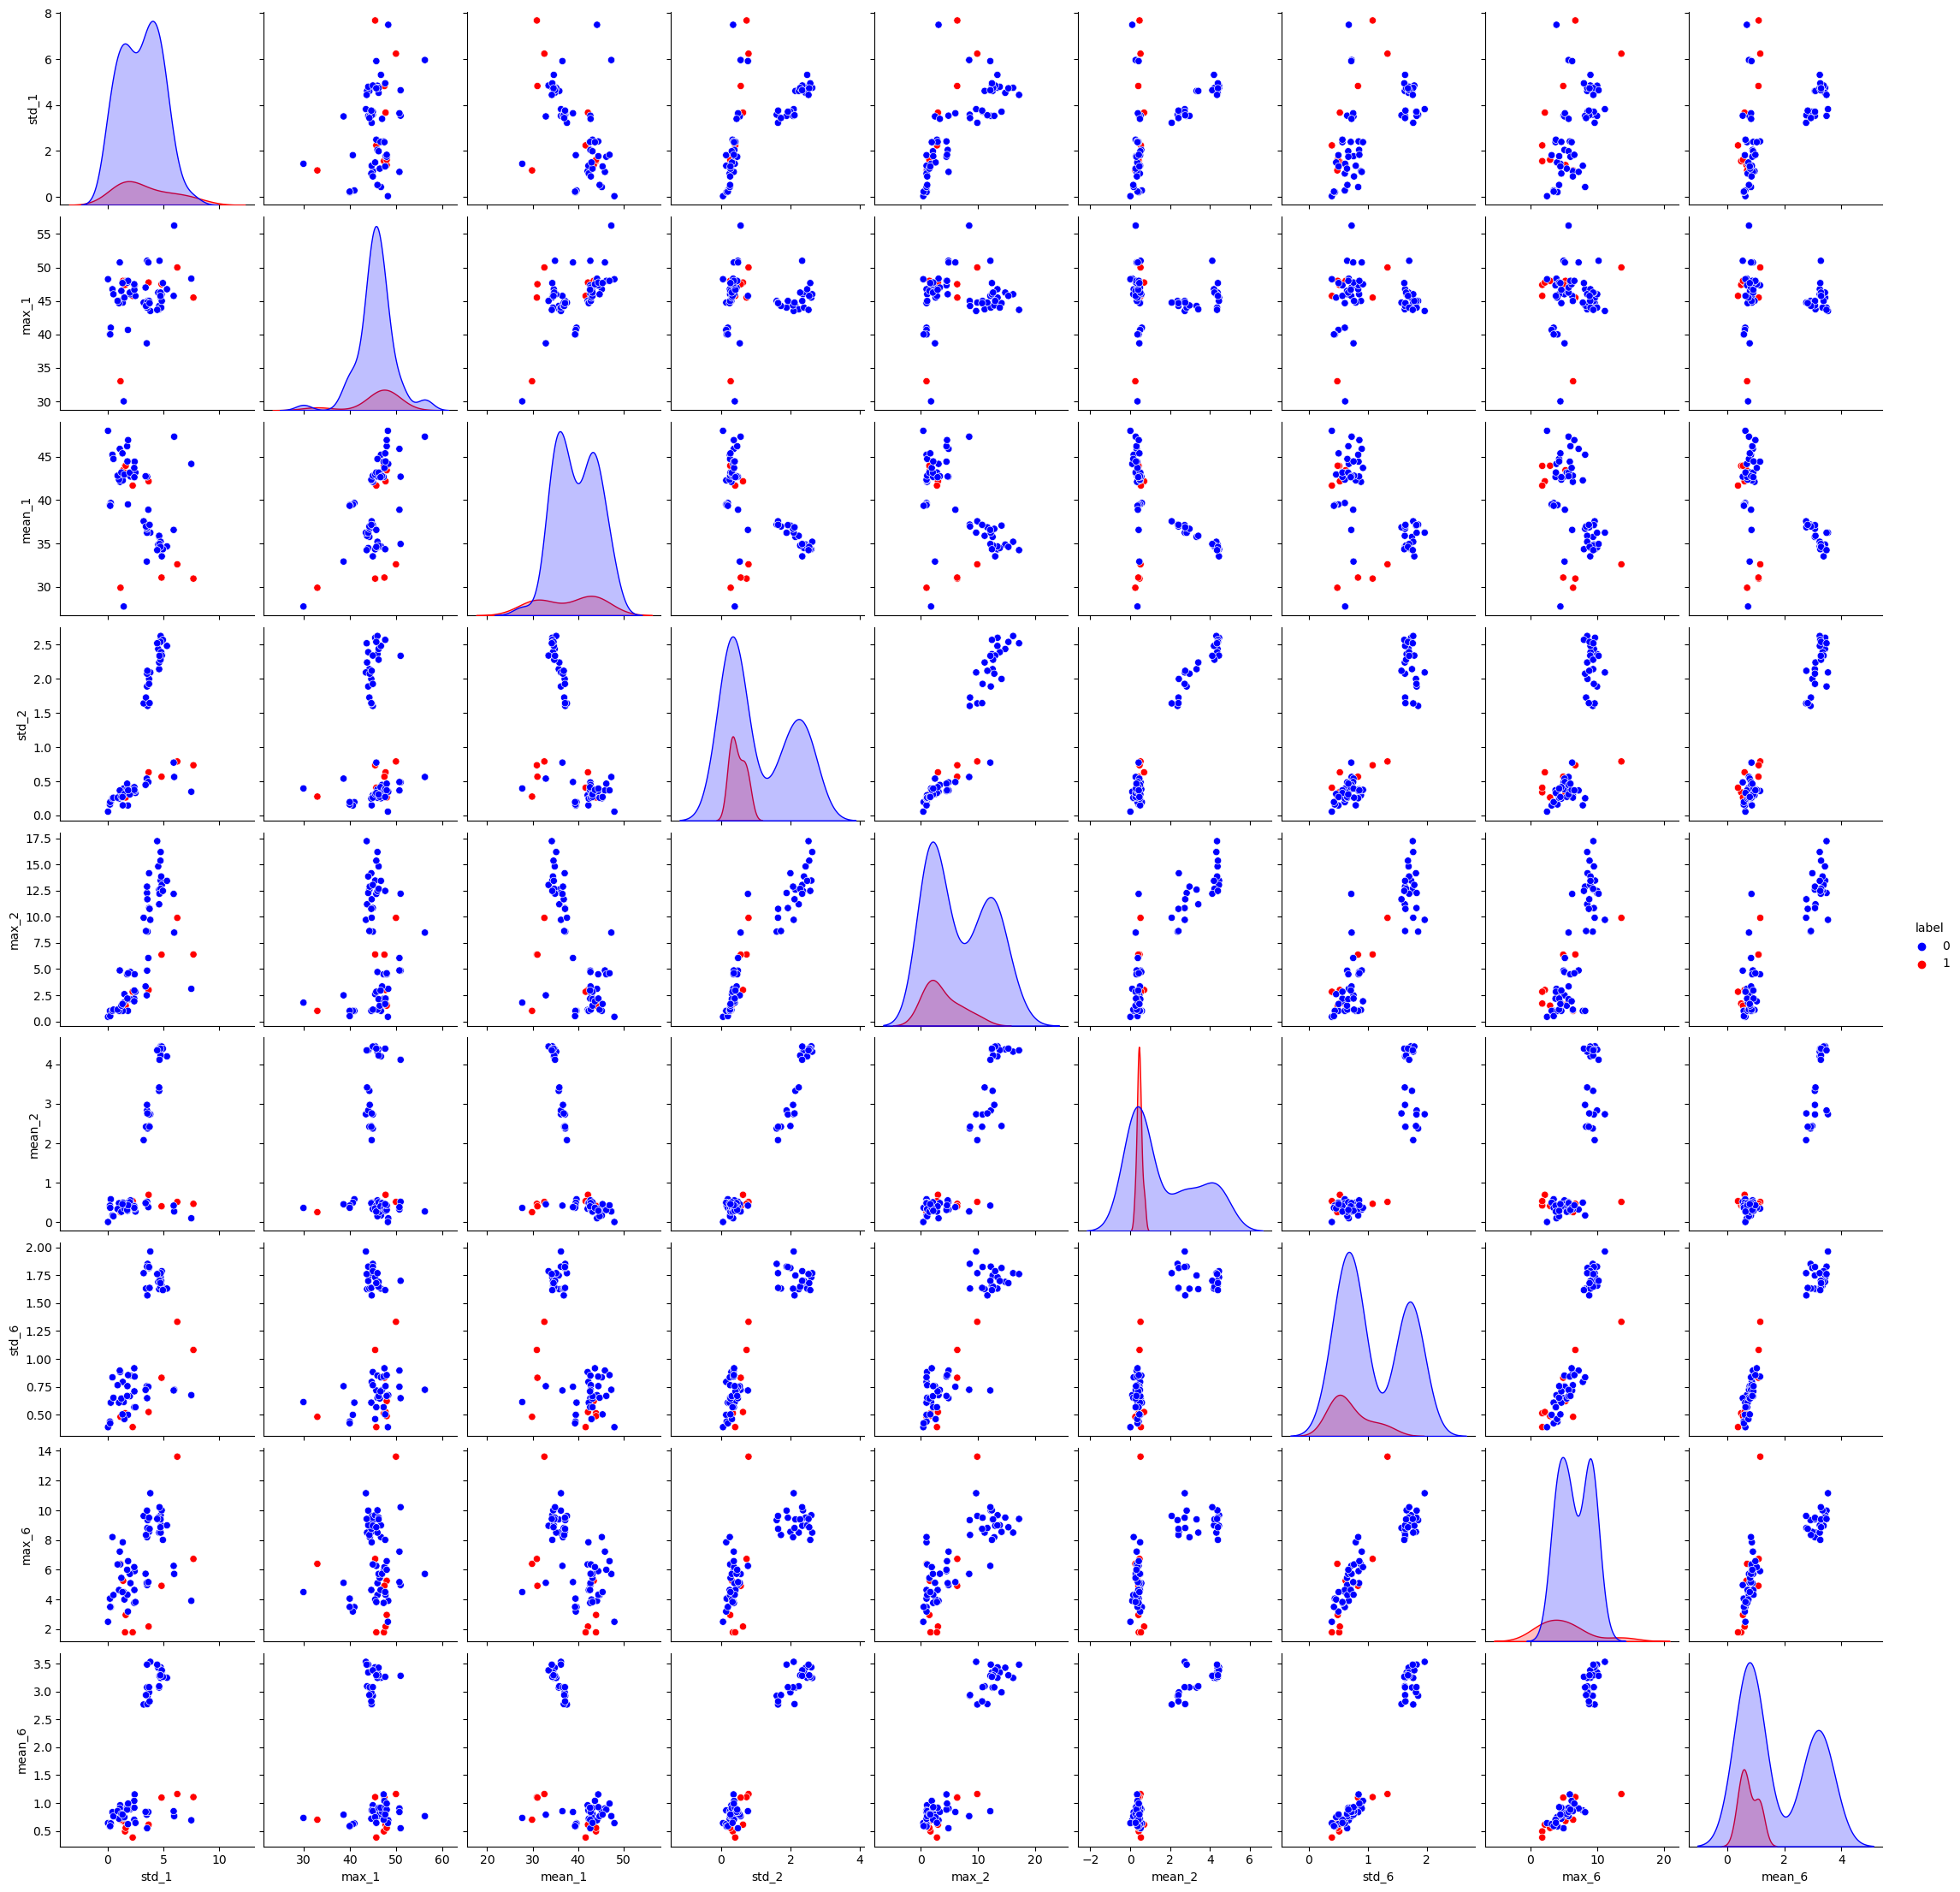

In [162]:

bending_name = []
for i in range(len(train_data_name)):
    if train_data_name[i] == 'bending1' or train_data_name[i] == 'bending2':
        bending_name.append(i)

specified_train_features = train_features[features].copy()

specified_train_features['label'] = [1 if i in bending_name else 0 for i in range(len(train_data_name))]

print(specified_train_features.head())

sns.pairplot(specified_train_features, hue='label', diag_kind='kde', palette={1: 'red', 0: 'blue'})

plt.show()

In [163]:
#2a（ii）

def split_data(train_data):
    first_half_list = [] 
    second_half_list = []
    
    for df in train_data:
        first_half = df.iloc[:240, :].reset_index(drop=True) 
        second_half = df.iloc[240:, :].reset_index(drop=True)
        
        first_half_list.append(first_half)
        second_half_list.append(second_half)
    
    return first_half_list, second_half_list

first_half_data, second_half_data = split_data(train_data)

print("First half length:", len(first_half_data))
print("Second half length:", len(second_half_data))

print("First half shape of first dataset:", first_half_data[0].shape)
print("Second half shape of first dataset:", second_half_data[0].shape)

First half length: 69
Second half length: 69
First half shape of first dataset: (240, 7)
Second half shape of first dataset: (240, 7)


First half data featur:     std_1  max_1  mean_1  std_2  max_2  mean_2  std_6  max_6  mean_6  label
0    1.56  46.50   44.06   0.33   1.50    0.38   0.53   1.79    0.60      1
1    3.47  47.75   43.28   0.63   3.00    0.67   0.55   1.53    0.64      1
2    3.12  45.75   41.62   0.49   2.83    0.62   0.41   1.79    0.42      1
3    1.36  48.00   44.12   0.31   1.30    0.25   0.72   5.26    0.82      1
4    1.28  45.00   43.49   0.28   1.30    0.38   0.49   2.28    0.52      1
..    ...    ...     ...    ...    ...     ...    ...    ...     ...    ...
64   4.73  46.00   34.97   2.33  12.68    4.21   1.64   8.83    3.15      0
65   4.28  45.67   34.74   2.34  12.21    4.22   1.74   9.19    3.33      0
66   5.14  45.00   33.89   2.45  12.44    4.33   1.57   7.89    3.25      0
67   4.87  44.00   34.84   2.51  12.38    4.26   1.65   8.86    3.17      0
68   4.55  42.75   34.33   2.47  14.50    4.32   1.73   9.42    3.38      0

[69 rows x 10 columns]
Second half data featur:     std_1  max_

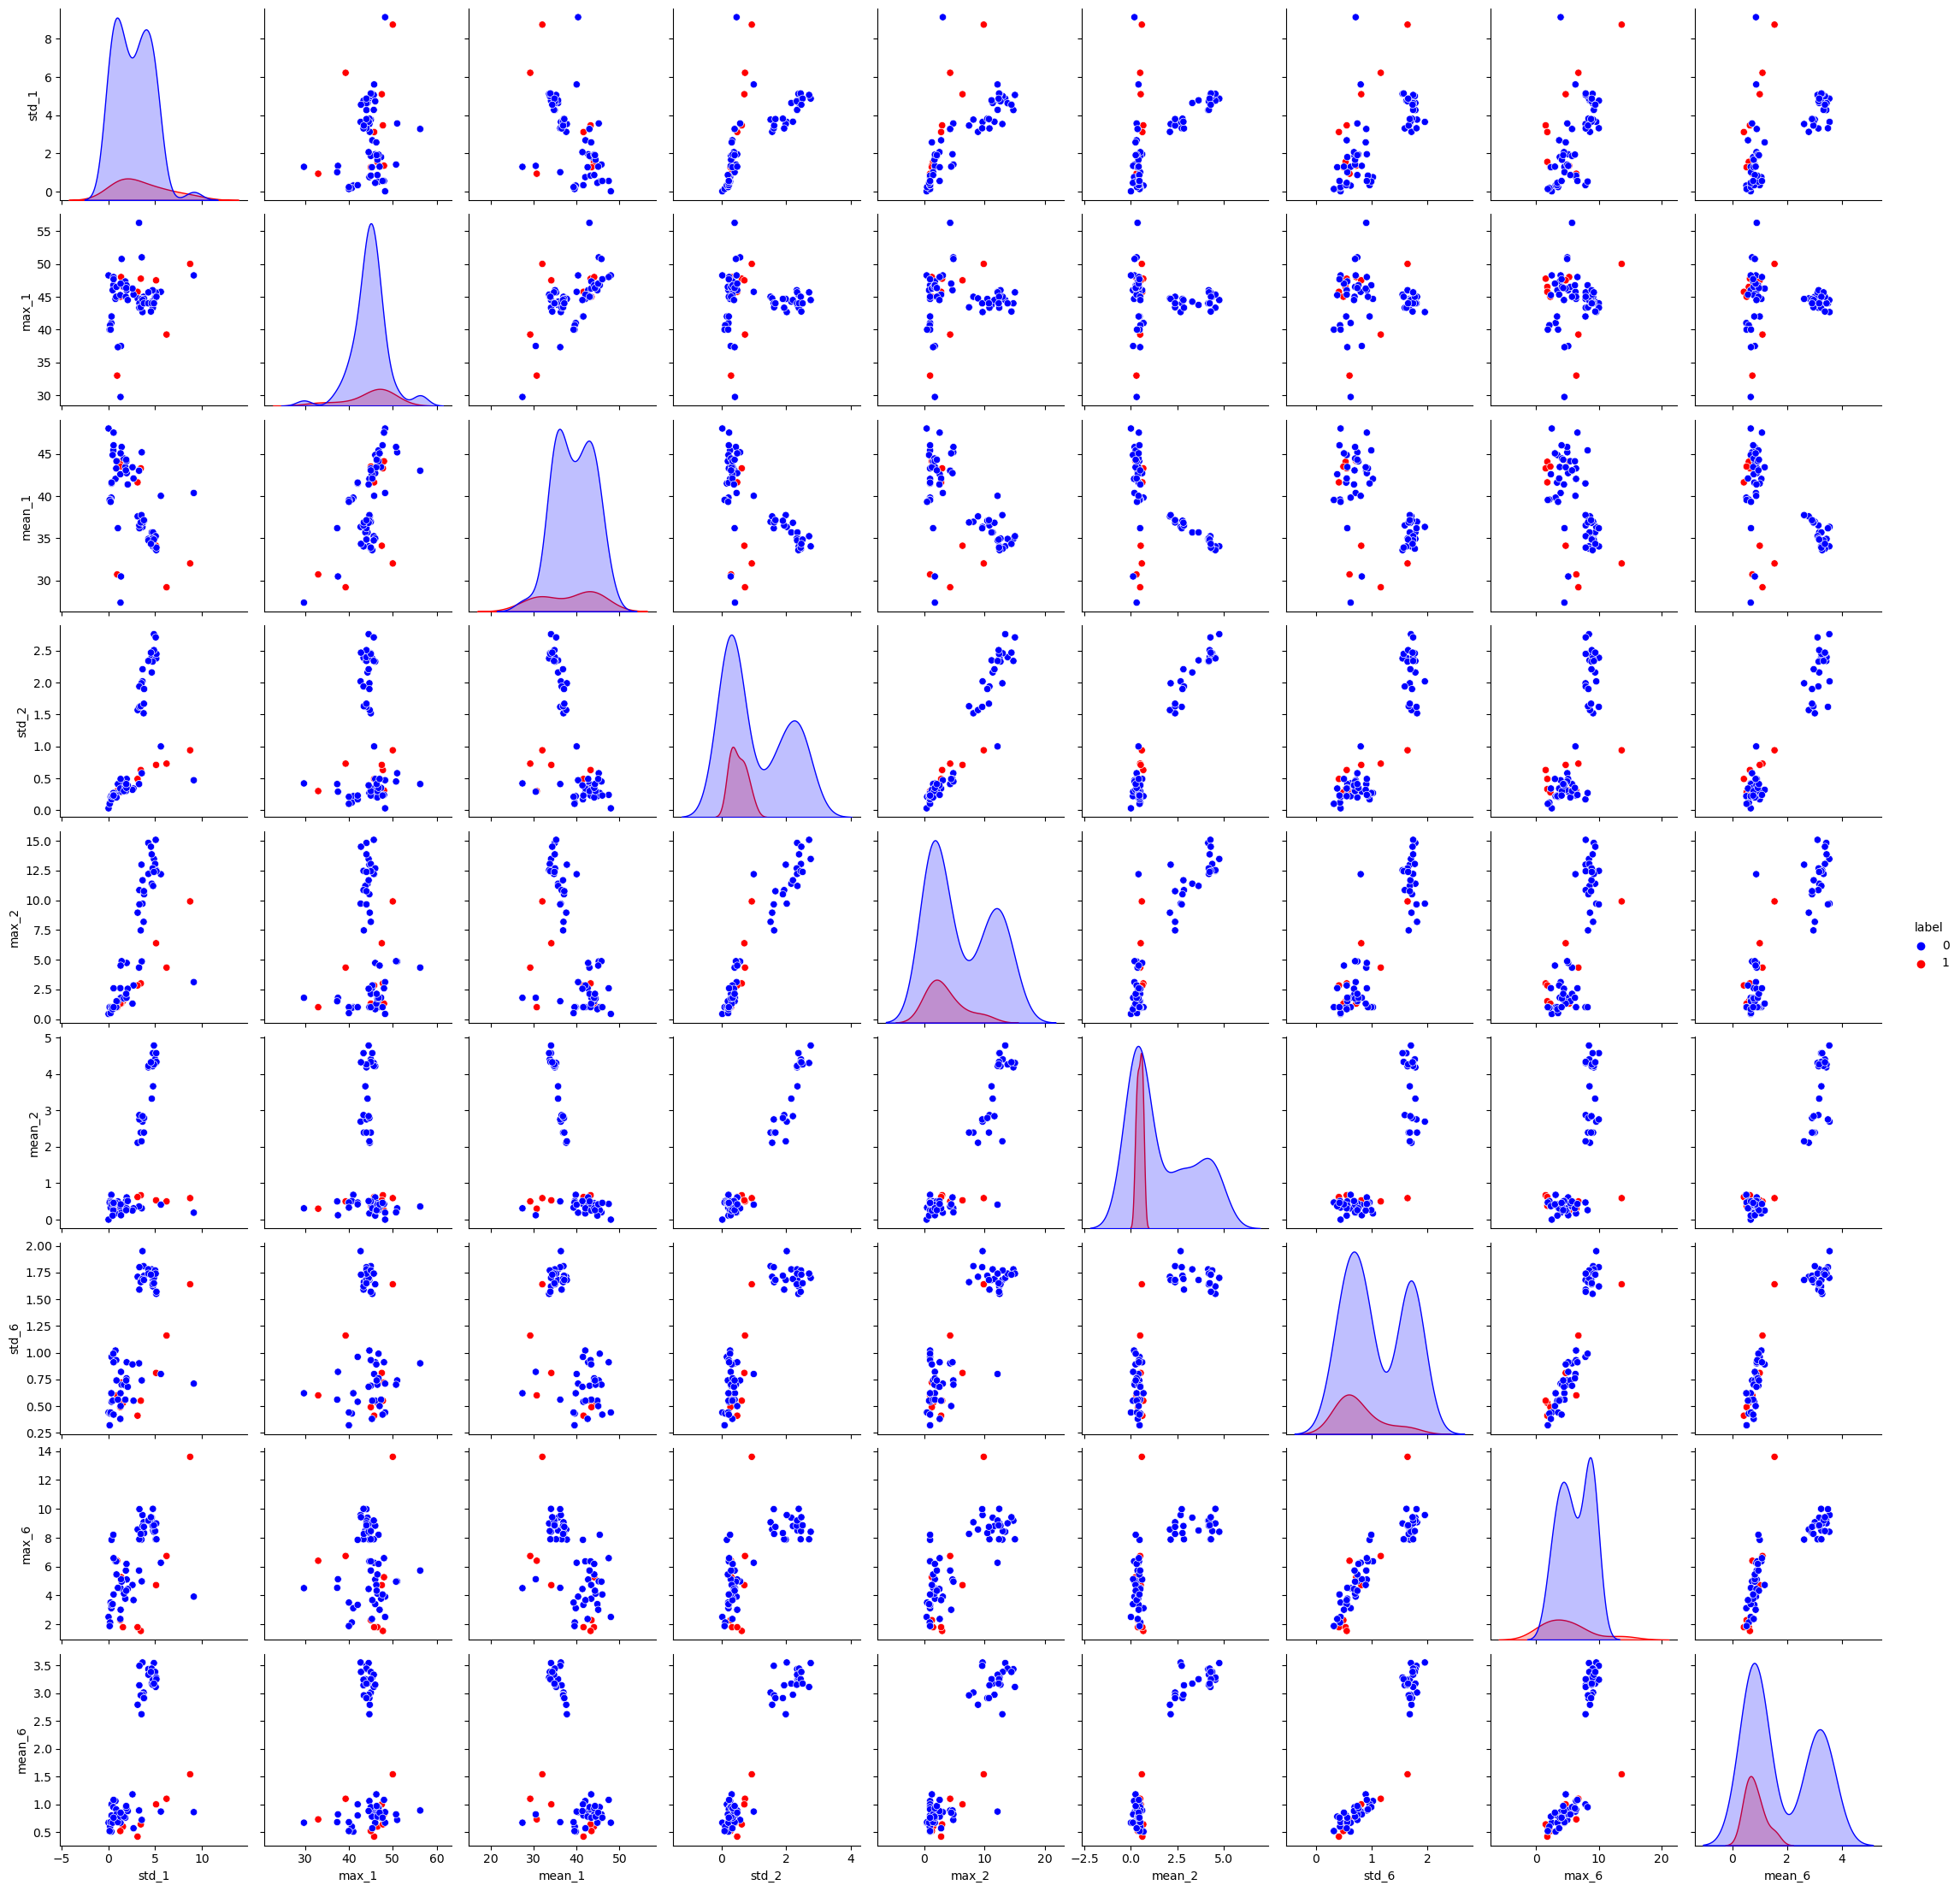

In [164]:
first_half_data_feature = pd.DataFrame([extract_features(df) for df in first_half_data]).round(2)
second_half_data_feature = pd.DataFrame([extract_features(df) for df in second_half_data]).round(2)


first_half_data_features = first_half_data_feature[features].copy()
second_half_data_features = second_half_data_feature[features].copy()


first_half_data_features['label'] = [1 if i in bending_name else 0 for i in range(len(train_data_name))]
second_half_data_features['label'] = [1 if i in bending_name else 0 for i in range(len(train_data_name))]


print("First half data featur:", first_half_data_features)
print("Second half data featur:", second_half_data_features)

sns.pairplot(first_half_data_features, hue='label', diag_kind='kde', palette={1: 'red', 0: 'blue'})

plt.show()

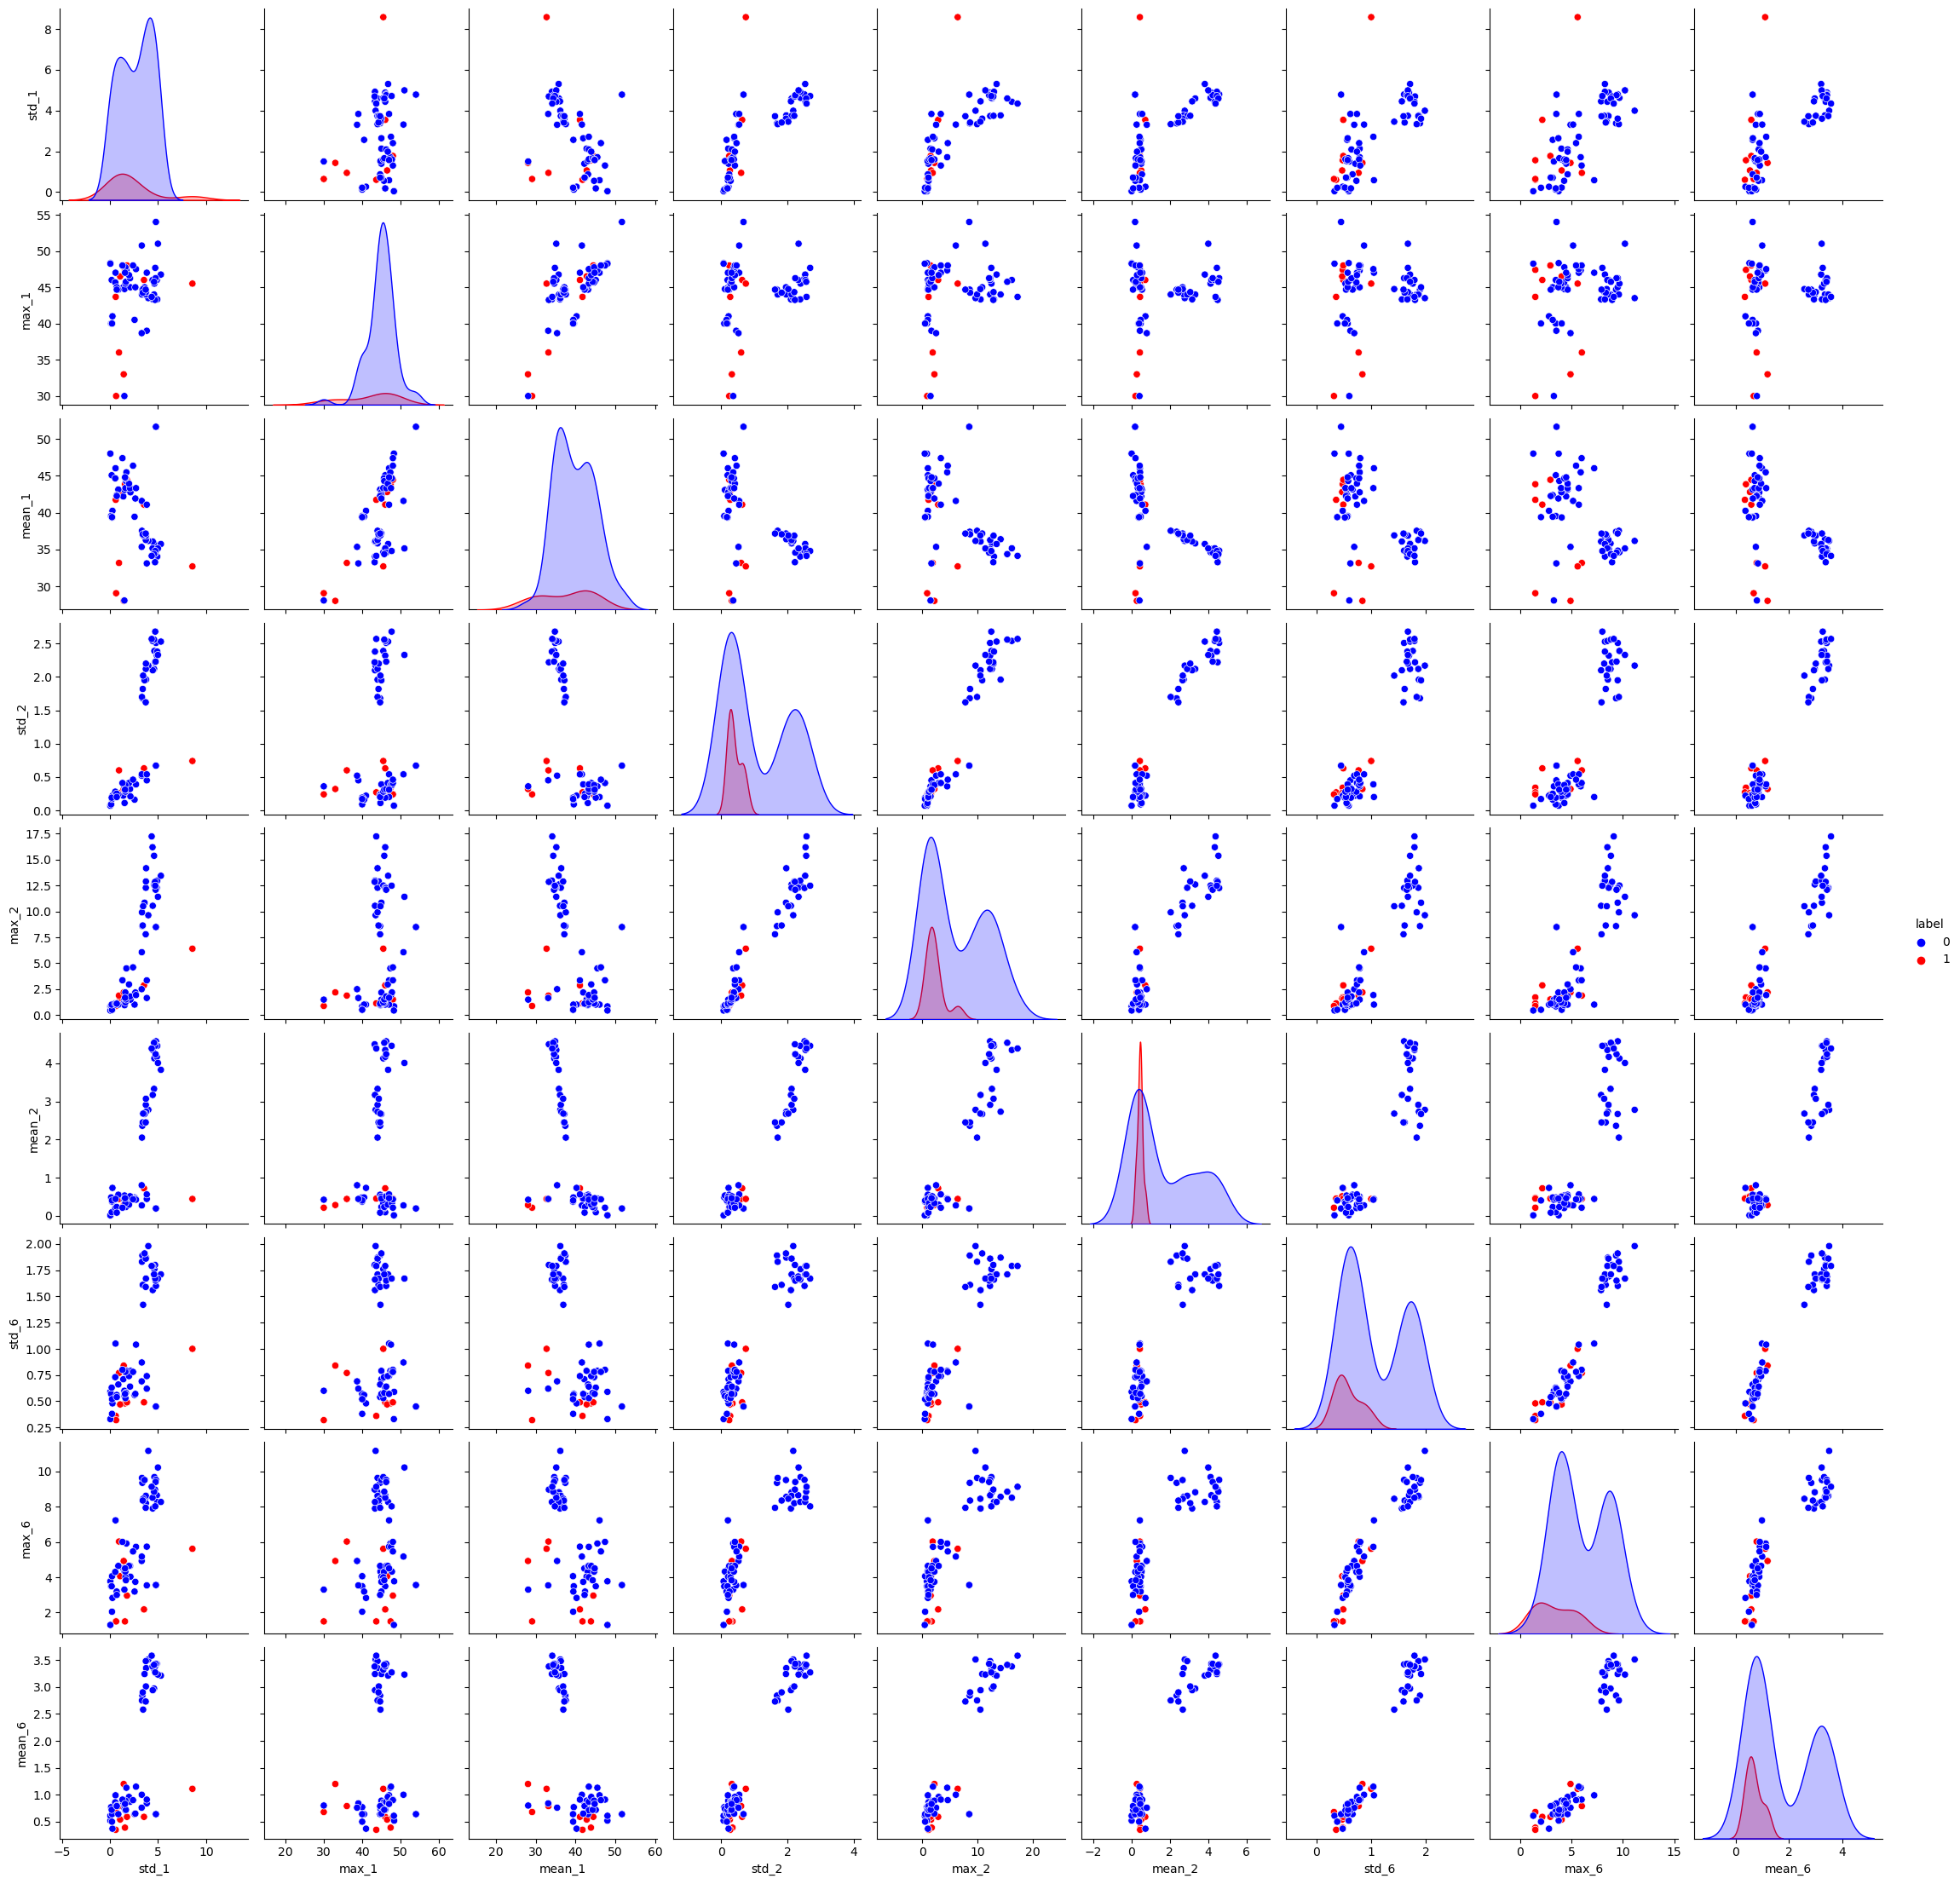

In [165]:
sns.pairplot(second_half_data_features, hue='label', diag_kind='kde', palette={1: 'red', 0: 'blue'})
plt.show()

I think there is no obvious difference between the two pictures, so I think the difference between 2aii and 2ai is not obvious

In [166]:
#2a（iii）

def split_time_series(train_data, l):
    
    processed_data = []

    for df in train_data:
        segment_size = len(df) // l 
        features = {}

        for i in range(l):
            segment = df.iloc[i * segment_size: (i + 1) * segment_size]

            for j, col in enumerate(df.columns[1:], 1):
                features[f'std_{j}_part{i+1}'] = segment[col].std()
                features[f'max_{j}_part{i+1}'] = segment[col].max()
                features[f'mean_{j}_part{i+1}'] = segment[col].mean()
                features[f'min_{j}_part{i+1}'] = segment[col].min()
                features[f'median_{j}_part{i+1}'] = segment[col].median()
                features[f'1st_quart_{j}_part{i+1}'] = segment[col].quantile(0.25)
                features[f'3rd_quart_{j}_part{i+1}'] = segment[col].quantile(0.75)

        processed_data.append(features)

    return pd.DataFrame(processed_data)

def recursive_feature_elimination(train_data, y, L):
    
    best_l = None
    best_p = None
    highest_accuracy = 0
    top_features = []

    #this part I used chatgpt to help me use rfe
    for l in L:
        split_features = split_time_series(train_data, l)
        X = split_features

        model = LogisticRegression(max_iter=1000, solver='liblinear')

        rfe = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits=5))
        rfe.fit(X, y)

        mean_cv_score = np.mean(rfe.cv_results_['mean_test_score'])
        
        if mean_cv_score > highest_accuracy:
            highest_accuracy = mean_cv_score
            best_l = l
            best_p = rfe.n_features_
            top_features = [i for i, support in enumerate(rfe.support_) if support]

    selected_features = split_features.columns[top_features]
    print(f"Best result: l = {best_l}, p = {best_p}, accuracy = {highest_accuracy:.4f}\n")
   
    X_final = split_features[selected_features]
    X_final = sm.add_constant(X_final)
    logit_model = sm.Logit(y, X_final)
    result = logit_model.fit(disp=False)

    print("\nbetai is:")
    print(result.params)
    print("\nP-value:")
    print(result.pvalues)

    return result, best_l, best_p, highest_accuracy, top_features, X_final, logit_model

y = [1 if 'bending' in name else 0 for name in train_data_name]

L = list(range(1, 21))

result, best_l, best_p, best_accuracy, best_features, X_final, logit_model = recursive_feature_elimination(train_data, y, L)


Best result: l = 1, p = 4, accuracy = 0.9813


betai is:
const               -2.463894
3rd_quart_1_part1   -0.369600
max_2_part1         -1.289184
max_5_part1          0.889327
min_5_part1         -0.143858
dtype: float64

P-value:
const                0.772352
3rd_quart_1_part1    0.137225
max_2_part1          0.162048
max_5_part1          0.093997
min_5_part1          0.651559
dtype: float64


Confusion Matrix is: 
 [[59  1]
 [ 2  7]]
Accuracy is: 0.9565

AUC is: 0.9944


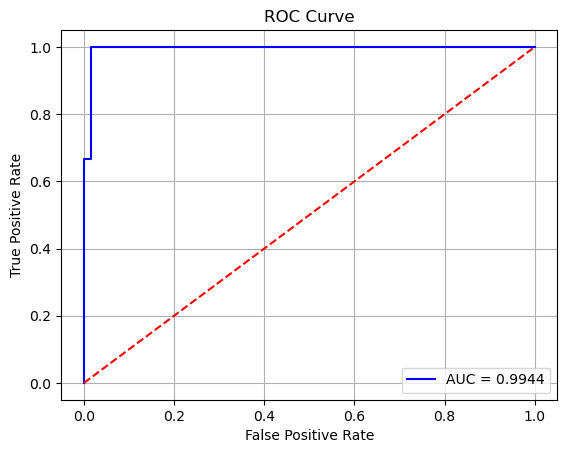

In [167]:
#2a（iv）

def evaluate_classifier(X_final, y, model_logit):
    y_pred_prob = model_logit.predict(X_final)
    y_pred = (y_pred_prob > 0.5).astype(int)

    Confusion_matrix = confusion_matrix(y, y_pred)
    print("Confusion Matrix is: \n", Confusion_matrix)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy is: {accuracy:.4f}\n")
    
    fpr, tpr, _ = roc_curve(y, y_pred_prob) 
    auc_score = roc_auc_score(y, y_pred_prob)
    print(f"AUC is: {auc_score:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

evaluate_classifier(X_final, y, result)



Accuracy on test set: 0.7895

Confusion Matrix on Test Set:
 [[11  4]
 [ 0  4]]
AUC on test set: 1.0000


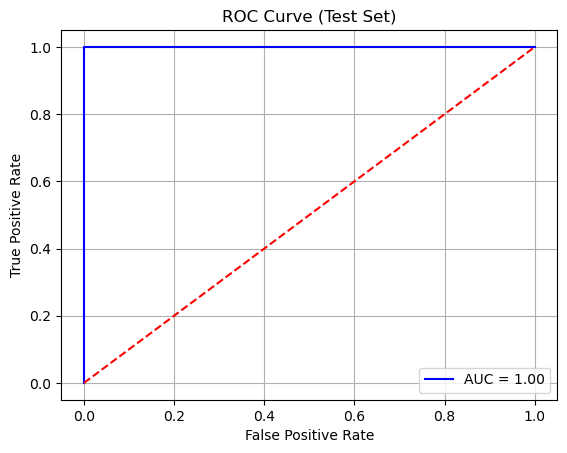

In [168]:
#2a（v）
def evaluate_on_test_set(test_data, y_test, l, selected_features, model_logit_result):
    
    X_test = split_time_series(test_data, l)[selected_features] 
    X_test = sm.add_constant(X_test, has_constant='add')

    y_test_pred_prob = model_logit_result.predict(X_test)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"\nAccuracy on test set: {test_accuracy:.4f}")

    Confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix on Test Set:\n", Confusion_matrix_test)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)
    print(f"AUC on test set: {auc_test:.4f}")

    plt.figure()
    plt.plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

y_test = [1 if 'bending' in name else 0 for name in test_data_name] 
selected_features = X_final.columns.difference(['const']) 

evaluate_on_test_set(test_data, y_test, best_l, selected_features, result)

### 2a vi
Yes, looking at my test accuracy, my test accuracy is very low, only 0.78, but my AUC is indeed a perfect 1. However, from the Confusion Matrix, we can see that there are four False Positives, indicating that 4 negative samples are incorrectly classified as positive. This means that although all positive samples are perfectly classified, nearly half of the parent class samples are classified as positive, which leads to a decrease in accuracy. So my classification may be too well separated, resulting in instability in the calculation of logistic regression parameters. This may be overfitting or a perfect separation problem. I have encountered the problem of Perfect Separation before, so I also tried to reduce the number of features but the effect was not ideal. I think I may need regularization or adjustment of the model to better improve the problem.

### 2a vii
From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

According to the reply above, there are a total of 15 negative samples and 4 positive samples. All positive samples were classified correctly, but 4 negative samples, were not classified correctly, so there are 4 False Positives. So it can be clearly seen that my model may have too good separation, and the number of positive samples is obviously lower than the negative samples.


Accuracy on test set: 0.7895

Confusion Matrix on Test Set:
 [[11  4]
 [ 0  4]]
AUC on test set: 1.0000


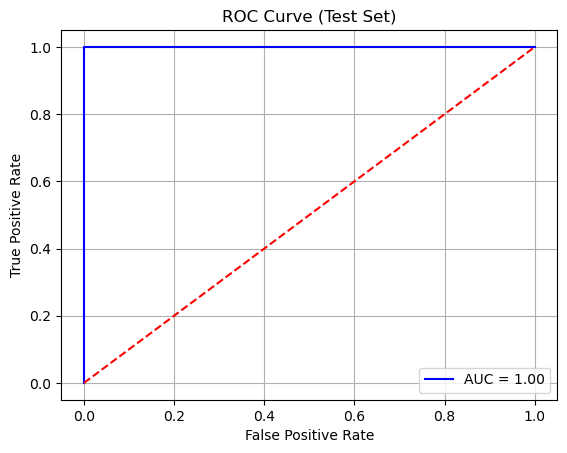

In [169]:
def Case_control_sampling(X_train, y_train, selected_features):

    logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
    logistic_model.fit(X_train[selected_features], y_train)

    return logistic_model


selected_features = X_final.columns.difference(['const'])
model_case_control = Case_control_sampling(X_final, y, selected_features)

X_test = split_time_series(test_data, best_l)[selected_features]

y_test_pred_prob = model_case_control.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy on test set: {test_accuracy:.4f}")

Confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix on Test Set:\n", Confusion_matrix_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)
print(f"AUC on test set: {auc_test:.4f}")

plt.figure()
plt.plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


(b)Binary Classification Using
L
1
-penalized logistic regression
i.
Repeat 2(a)iii using
L
1
-penalized logistic regression,
8
i.e. instead of using p-
values for variable selection, use
L
1
regularization. Note that in this problem,
you have to cross-validate for both
l
, the number of time series into which you
break each of your instances, and
λ
, the weight of
L
1
penalty in your logistic
regression objective function (or
C
, the budget). Packages usually perform
cross-validation for
λ
automatically.

In [170]:
#2bi
def logistic_regression_l1_cv(train_data, y, L, C_values):
    best_l = None
    highest_accuracy = 0
    best_features = []

    for l in L:
        split_features = split_time_series(train_data, l)
        X = split_features

        #use chatgpt to help me use LogisticRegressionCV and find model mean
        model = LogisticRegressionCV(Cs=C_values,penalty='l1', solver='liblinear', class_weight='balanced')

        model.fit(X, y)
        mean_cv_score = model.scores_[1].mean(axis=0).max()

        if mean_cv_score > highest_accuracy:
            highest_accuracy = mean_cv_score
            best_l = l
            best_c = model.C_[0]
            best_features = np.where(model.coef_[0] != 0)[0]

    selected_features = split_features.columns[best_features]
    return best_l, best_c, highest_accuracy, selected_features

C_values = np.logspace(-4, 4, 100)

best_l, best_c, best_accuracy, selected_features = logistic_regression_l1_cv(train_data, y, L, C_values)

print(f"Best selected feature: {selected_features}")
print(f"Best l: {best_l}, Best C: {best_c:.4f}, Best accuracy: {best_accuracy:.4f}")

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best selected feature: Index(['3rd_quart_1_part1', 'max_2_part1', 'max_5_part1', 'min_5_part1',
       '3rd_quart_1_part2', 'max_1_part3', 'min_5_part3'],
      dtype='object')
Best l: 3, Best C: 0.0977, Best accuracy: 1.0000


2b ii.
Compare the
L
1
-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

Comparing L1-penalized and p-value, L1-penalized definitely performs better. As I mentioned before, my code has problems with multicollinearity and overfitting. I received an error message in 2(a)iii because my model has multicollinearity, so I guess this is the reason why my test accuracy is not ideal. Therefore, I really need to add l1 penalized or l2 penalized to reduce the collinearity of my model. According to my results, when l=3, C=0.0977, the accuracy of my training data reached an astonishing 1.0, while the p-value was only 0.9813. In addition, l1 penalized is easier to implement, but the choice of p requires more manual intervention.

In [180]:
#2ci

def l1_multinomial_regression(train_data, y, L, C_values):
    best_l = None
    best_accuracy = 0
    best_features = []

    for l in L:  
        split_features = split_time_series(train_data, l)
        X = split_features

        model = LogisticRegressionCV(
            Cs=C_values, 
            penalty='l1', 
            solver='saga', 
            max_iter=1000,
            cv=StratifiedKFold(n_splits=5),
            scoring='accuracy',
            random_state=42
        )
        
        model.fit(X, y)

        mean_cv_score = model.scores_[1].mean(axis=0).max()

        if mean_cv_score > best_accuracy:
            best_accuracy = mean_cv_score
            best_l = l
            best_c = model.C_[0]  
            best_features = np.where(model.coef_[0] != 0)[0]  

    selected_features = split_features.columns[best_features]
   
    X_final = split_features[selected_features]
    X_final = sm.add_constant(X_final)
    logit_model = sm.Logit(y, X_final)
    result = logit_model.fit(disp=False)

    print(f"Best result: l = {best_l}, C = {best_c}, accuracy = {best_accuracy:.4f}\n")
    return result, best_l, best_c, best_accuracy, selected_features, X_final, logit_model

C_values = np.logspace(-4, 4, 100)
result, best_l, best_c, best_accuracy, selected_features, X_final, logit_model = l1_multinomial_regression(train_data, y, L, C_values)

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\wumin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best result: l = 1, C = 0.24770763559917114, accuracy = 1.0000




Accuracy on test set: 1.0000

Confusion Matrix on Test Set:
 [[15  0]
 [ 0  4]]
AUC on decision scores: 1.0000


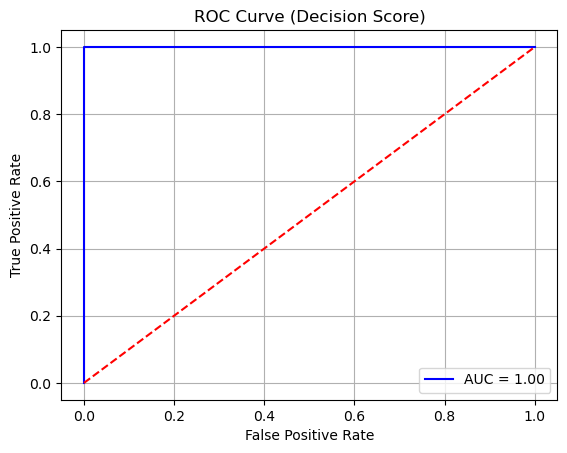

In [181]:
model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', C=best_c, max_iter=1000)
model.fit(X_final[selected_features], y)

X_test_processed = split_time_series(test_data, best_l)
X_test_selected = X_test_processed[selected_features]
y_test = [1 if 'bending' in name else 0 for name in test_data_name]
y_pred = model.predict(X_test_selected)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on test set: {test_accuracy:.4f}")

Confusion_matrix_test = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix on Test Set:\n", Confusion_matrix_test)

y_score = model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
print(f"AUC on decision scores: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Decision Score)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Test Accuracy: 0.5789
Test Confusion Matrix:
[[7 8]
 [0 4]]
AUC on decision scores: 1.0000


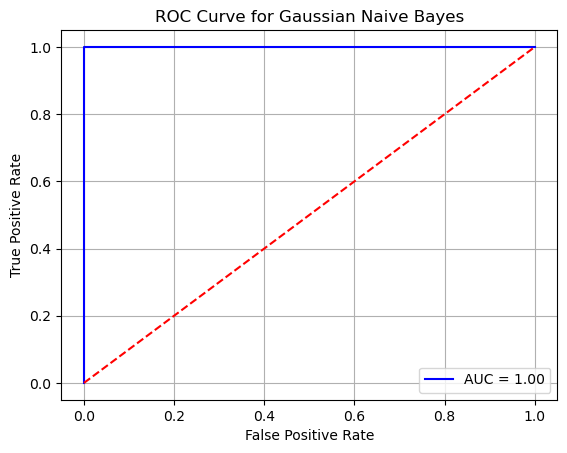

Test Accuracy: 1.0000
Test Confusion Matrix:
[[15  0]
 [ 0  4]]
AUC on decision scores: 1.0000


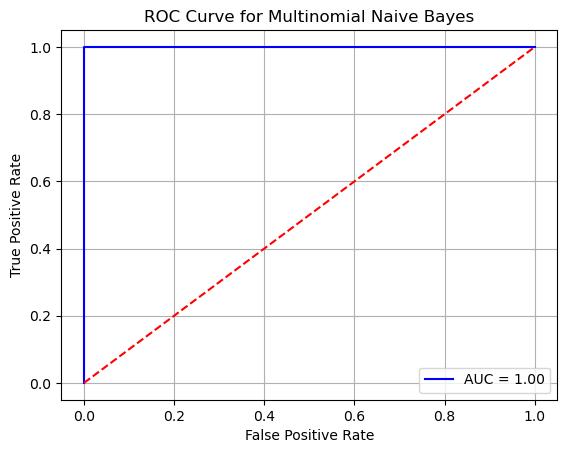

In [176]:
X_train = split_time_series(train_data, l)
y_train = [1 if 'bending' in name else 0 for name in train_data_name]

X_test = split_time_series(test_data, l)
y_test = [1 if 'bending' in name else 0 for name in test_data_name]

def train_evaluate_naive_bayes(X_train, y_train, X_test, y_test, model_type='gaussian'):
    if model_type == 'gaussian':
        model = GaussianNB()
    else:
        model = MultinomialNB()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Confusion Matrix:\n{test_confusion_matrix}")

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    print(f"AUC on decision scores: {roc_auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_type.capitalize()} Naive Bayes")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

train_evaluate_naive_bayes(X_train, y_train, X_test, y_test, model_type='gaussian')
train_evaluate_naive_bayes(X_train, y_train, X_test, y_test, model_type='multinomial')


### 2ciii
Based on the accuracy for test data, Multinomial Naive Bayes has the highest test accuracy which is 1, so I think Multinomial Naive Bayes is the best model. Multinomial Naive Bayes (MNB) is usually used to deal with discrete features, which may mean that my data is more discrete and colorful and my data is multinomial distributed rather than normally distributed, but it may be due to overfitting, because the sample size is uneven.

### ISLR 4.8.3

from Bayes Classifier：


P(Y=k|X=x) = P(X=x|Y=k)P(Y=k) / P(X=x)

and since the probability density function of a normal distribution is:
P(X=x|Y=k) = 1/(sqrt(2pisigmak^2) exp(-(x-muk^2) / 2sigmak^2)

fk(x) = P(X=x|Y=k)
pik = P(Y=k) 

so Pk(X) = P(Y=k|X=x) = P(X=x|Y=k)P(Y=k) / P(X=x) = pikfk(x) / sum(l=1 to K) pilfl(x)

for quadratic discriminant analysis:
K* = argmax Pk(x)

when p = 2

K* = argmax log pik - log sqrt(2sigma) sigmak - x^2/2sigmak^2 + mukx / sigma^2 - muk^2/2sigmak^2

therefore since we have  x^2 terms, the Bayes Classifier is quadratic instead of linear.  


### ISLR 4.8.7

f(x) = 1/sqrt(2*pi*sigma^2) * e^(-(x-mu)^2 / 2*sigma^2

Pk(Y = k| X = x) = pik * fk(x) / sum(pil * fl(x))

mu yes = 10
mu no = 0
sigmayes^2 = sigmano^2 = 36

piyes = 0.8
pino = 0.2

X= 4

Pk(Y = ‘yes’|X=4) = piyes * fyes(4) / (pi yes * f yes(4) + pino * fno(4))

fyes(4) = 1/6*sqrt(2pi) * e(-1/(2 * 36) * (4-10)^2) = 0.040325

fno(4) = 1/6*sqrt(2pi) * e(-1/(2 * 36) * (4-0)^2) = 0.05325

Pk(Y = ‘yes’|X=4) = 0.8*0.04/(0.8*0.04 + 0.2 * 0.053) = 0.752 = 75.2%
